In [21]:
import pandas as pd
import numpy as np

In [22]:
from src.config import *
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
lincs_consensus = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col=0)
lincs_design_matrix = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)


In [25]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_s0_229.csv', index_col = 0)

In [ ]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]

In [59]:
conf_rocauc_cytosig = pd.read_csv('results/benchmark/cytosig_lincs_rocauc_confidence.csv', index_col =0)

In [52]:
temp = pd.concat([lincs_design_matrix.abs().sum().sort_values(), confidence_scores.set_index('Receptor')['ROCAUC']], axis = 1)
temp.columns = ['Number_of_sigs', 'ROCAUC']

In [53]:
temp = temp.merge(lr_associations.groupby('target_genesymbol').count().sort_values(by = 'source_genesymbol')
, left_index = True, right_index = True, how = 'left')
temp = temp.rename(columns = {'source_genesymbol':'number_of_associated_ligands'})
temp.head()

,Number_of_sigs,ROCAUC,number_of_associated_ligands
CD27,7,0.850172,1
FSHR,12,0.774299,2
APLNR,17,0.858800,2
UTS2R,17,0.843013,2
LPAR4,18,0.701761,1


In [138]:
temp.sort_values(by = 'Number_of_sigs', ascending = False).head(10)

,Number_of_sigs,ROCAUC,number_of_associated_ligands
EGFR,1648,0.641483,16
KIT,1475,0.619873,1
PDGFRB,1206,0.639428,4
KDR,1101,0.534518,6
FLT1,852,0.655659,6
FLT3,851,0.463797,1
HTR2C,820,0.601188,1
PDGFRA,804,0.581644,4
AR,738,0.591460,1
ERBB2,737,0.742131,4


<AxesSubplot:xlabel='ROCAUC', ylabel='Number_of_sigs'>

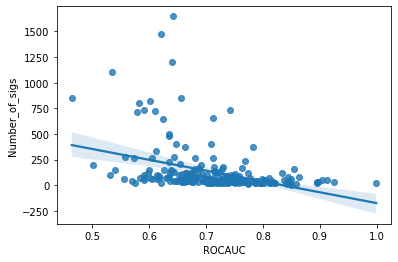

In [132]:
sns.regplot(data = temp, x = 'ROCAUC', y = 'Number_of_sigs')

In [56]:
cytosig_data = pd.read_csv(f'data/cytosig/diff.merge.gz', compression='gzip', sep = '\t')
cytosig_data = cytosig_data.T

In [64]:
additional_mapping = {
       'IFNA':'IFNA1', 
       'IFNB':'IFNB1',
       'IFNL':'IFNL1', 
       'TNFA':'TNF', 
       'IL12':'IL12B', 
       'CD40L':'CD40LG', 
       'GMCSF':'CSF2', 
       'MCSF':'CSF1',
       'IL1':'IL1A', 
       'TWEAK':'TNFRSF12A',
       'TRAIL':'TNFSF10',
       'GCSF':'CSF3',
       'IL32':'IL32',
       'OPGL':'TNFSF11',
       'BAFF':'TNFSF13B',
       '41BBL':'TNFSF9',
       'IL23':'IL23A', 
       'CXCL4':'PF4',
       'Activin A':'INHBA',
       'ANGPTL4':'ANGPTL4',
       'ANGPTL2':'ANGPTL2',
       'PGE2':'PTGES2',
       'NO':'NO',
       'PDL1':'CD274'
}
inverse_additional_mapping = {v: k for k, v in additional_mapping.items()}

In [67]:
# get the gene symbol of cytosig cytokines
cytosig_cytokines = pd.DataFrame(index = cytosig_data.index, columns = ['cytokines'])
cytosig_cytokines['cytokines'] = cytosig_data.index.str.split('@', expand = True).get_level_values(0).str.split('&', expand = True).get_level_values(0)
cytosig_cytokines['cytokine_genesymbol'] = cytosig_cytokines['cytokines'].map(additional_mapping).fillna(cytosig_cytokines['cytokines'])

In [98]:
number_of_signatures_receptor_cytosig = {}
i = 0
a_receptors = conf_rocauc_cytosig[conf_rocauc_cytosig['ConfidenceLevel'] != 'all'].sort_values(by = 'ROC AUC')
for rec in a_receptors.index:
    ligandsofrec = lr_associations[lr_associations['target_genesymbol'] == rec]
    for lig in ligandsofrec.source_genesymbol:
        cytosig_cytokines_lig = cytosig_cytokines[cytosig_cytokines['cytokine_genesymbol'] ==lig]
        cytosig_cytokines_lig = {'receptor':rec, 'ligand':lig, 'number_of_sigs':len(cytosig_cytokines_lig)}
        number_of_signatures_receptor_cytosig[i] = cytosig_cytokines_lig
        i = i+1
number_of_signatures_receptor_cytosig = pd.DataFrame(number_of_signatures_receptor_cytosig).T

In [99]:
number_of_signatures_receptor_cytosig_sum = number_of_signatures_receptor_cytosig.groupby('receptor')[['number_of_sigs']].sum()

In [100]:
a_receptors2 = a_receptors.merge(number_of_signatures_receptor_cytosig_sum, left_index = True, right_index=True, how = 'left')

In [115]:
a_receptors2['ROC AUC'] = a_receptors2['ROC AUC'].astype(float)

<AxesSubplot:xlabel='ConfidenceLevel', ylabel='number_of_sigs'>

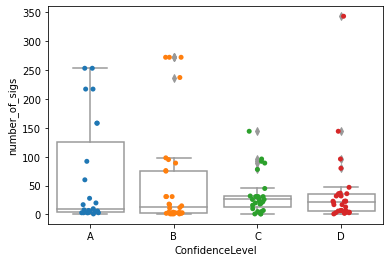

In [126]:
sns.boxplot(data = a_receptors2.sort_values(by = 'ConfidenceLevel'), y= 'number_of_sigs', x = 'ConfidenceLevel',color = 'white')
sns.stripplot(data = a_receptors2.sort_values(by = 'ConfidenceLevel'), y= 'number_of_sigs', x = 'ConfidenceLevel')

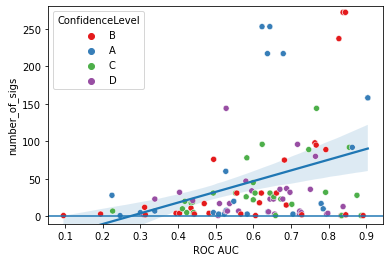

In [113]:
sns.regplot(data = a_receptors2, x = 'ROC AUC', y = 'number_of_sigs', scatter = False)
sns.scatterplot(data = a_receptors2, x = 'ROC AUC', y = 'number_of_sigs', hue = 'ConfidenceLevel', palette = 'Set1')

plt.ylim(-10, 280)
plt.axhline(0)

In [70]:
lr_associations[lr_associations['target_genesymbol'] == 'CD40']

,source_genesymbol,target_genesymbol
606,CD40LG,CD40
1413,LTB,CD40
